In [56]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import albumentations as A
from PIL import Image
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
from torchmetrics.functional.classification import binary_f1_score
from torchvision.transforms.functional import pil_to_tensor

In [28]:
image_dir = "./data/train/images"
mask_dir = "./data/train/masks"
assert os.path.exists(image_dir)
assert os.path.exists(mask_dir)

IMG_SHAPE = (448, 448)

In [29]:
def set_seeds():
    torch.manual_seed(0xC0FFEE)
    np.random.seed(0xC0FFEE)
set_seeds()

## Helper functions

In [30]:
def get_random_image_and_mask() -> tuple[Image, Image]:
    img_files = [f for f in os.listdir(image_dir)]

    file_name = random.choice(img_files)
    
    
    img_path = os.path.join(image_dir, file_name)
    mask_path = os.path.join(mask_dir, file_name)
    
    image = Image.open(img_path).convert("RGB") 
    
    mask = Image.open(mask_path).convert("L")

    return image, mask


In [31]:
def visualise_transform(image, transform):

    transformed_img = transform(image=np.array(image))["image"]
    fig, axs = plt.subplots(1,2)

    axs[0].imshow(image)
    axs[0].set_title("Original image")
    axs[0].axis("off")

    function_name = transform.__class__.__name__
    axs[1].imshow(transformed_img)
    axs[1].set_title(function_name)
    axs[1].axis("off")
    
    


In [93]:
def dice_score(prediction_mask, truth_mask):
    return binary_f1_score(prediction_mask.squeeze(), truth_mask.squeeze())

In [90]:
def predict(img, *, model):
    if len(img.shape) == 3:
        img = img[None,:,:,:]
    model.eval()
    with torch.no_grad():
        logits = model(img)
        probs = torch.sigmoid(logits)

        mask = probs > 0.5

    return mask.double()

In [97]:
def draw_random_predictions(model, num_of_images = 3):
    img_files = [f for f in os.listdir(image_dir)]
    selected_files = random.sample(img_files, num_of_images)

    fig, axs = plt.subplots(num_of_images,3, figsize=(10,10))
    
    for i, file_name in enumerate(selected_files):
        img_path = os.path.join(image_dir, file_name)
        mask_path = os.path.join(mask_dir, file_name)
        
        image = Image.open(img_path).convert("RGB") 
        
        mask = Image.open(mask_path).convert("L")
        
        tensor_image = pil_to_tensor(image).float()/255.0
        tensor_mask = torch.round(pil_to_tensor(mask).float()/255.0)
        
        prediction = predict(tensor_image, model = model)
        dice = dice_score(prediction, tensor_mask)
        
        axs[i,0].set_title("Image")
        axs[i,0].imshow(image)
        
        axs[i,1].set_title(f"Prediction (Dice: {dice:.2f})")
        axs[i,1].imshow(prediction[0,0].cpu(), cmap="gray")
        

        axs[i,2].imshow(tensor_mask.squeeze(), cmap="gray")
        axs[i,2].set_title("Ground Truth")
        


# Dataset overview

The dataset contains images of concrete with or without cracks, and masks of cracks

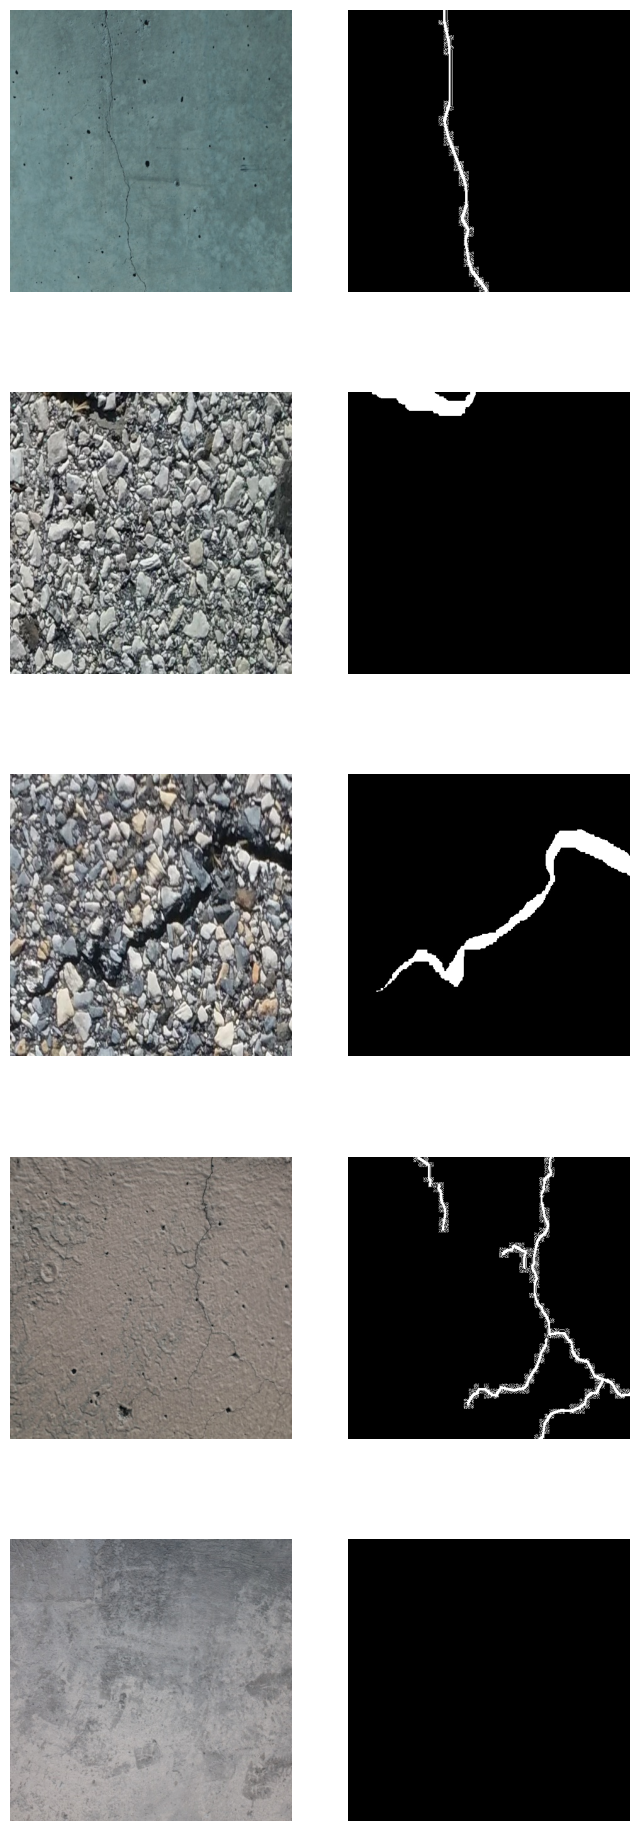

In [34]:
examples = 5
_, axs = plt.subplots(examples, 2, figsize = (8,24))
for i in range(5): 
    image, mask = get_random_image_and_mask()
    axs[i, 0].imshow(image)
    axs[i, 1].imshow(mask, cmap="gray")
    axs[i, 0].axis('off')  
    axs[i, 1].axis('off') 


# Preprocessing

<BarContainer object of 256 artists>

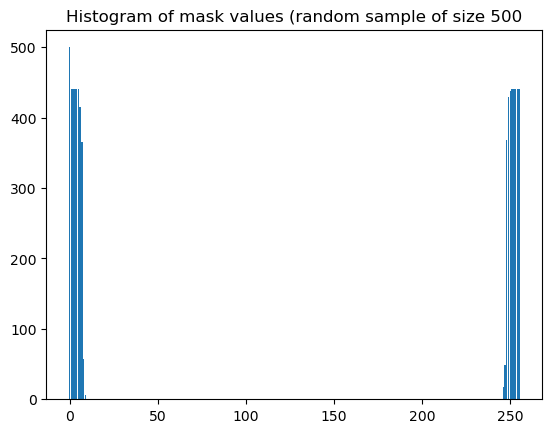

In [126]:
values = np.zeros((256,))
sample_size = 500
for _ in range(sample_size):
    _, mask = get_random_image_and_mask()
    values[np.unique(np.array(mask))] += 1

plt.title(f"Histogram of mask values (random sample of size {sample_size}")
plt.bar(range(256), values)



Some of the values in mask images are not entirely black or white, probably due to compression. Because the variation is very small, we just **round the values** to black or white

We also **normalize the pixels**, so the values lie between **0 and 1**

## Augumentations

We tried to train our networks with or without augumentations. 

When we did use it we concluded that such augumentations make sense

In [35]:
EXMAPLE_PER_TRANSFORM = 3

### Rotation

Cracks have an unoriented chaotic nature. Transformed images are different but seem very natural

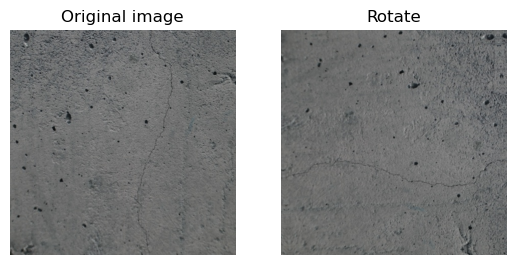

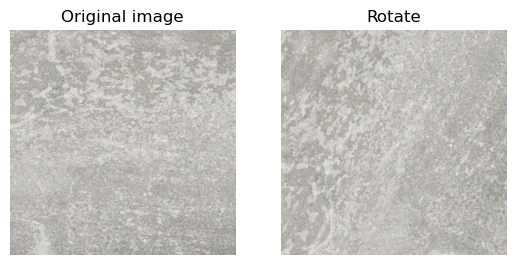

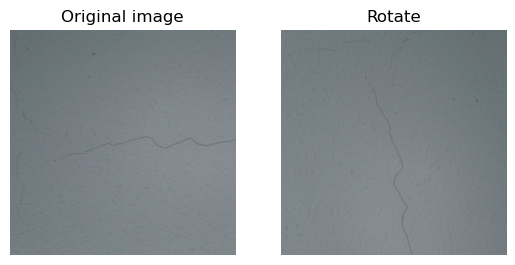

In [36]:
for _ in range(EXMAPLE_PER_TRANSFORM):
    img, _ = get_random_image_and_mask()
    visualise_transform(img, A.Rotate(limit=(-90,90),p=1))

### Vertical Flip

Crack is a crack in its mirror image

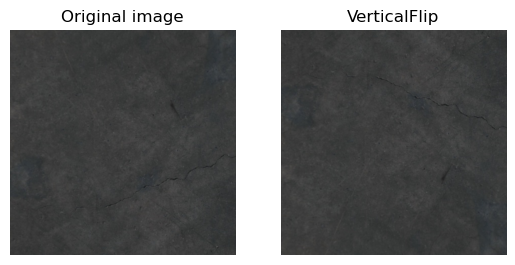

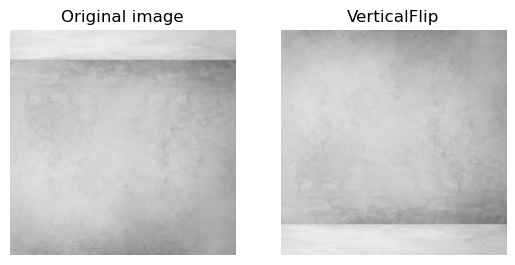

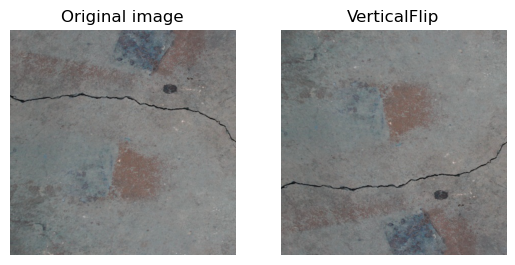

In [37]:
for _ in range(EXMAPLE_PER_TRANSFORM):
    img, _ = get_random_image_and_mask()
    visualise_transform(img,  A.VerticalFlip(p=1))

### Grid distortion

This transformation apply localized warping effects, by dividing it into a grid and creating localized warping effects. This makes sense, as crack forms a convoluted path, which after distortion still looks like a valid crack 

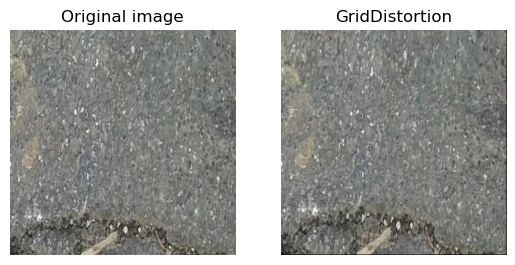

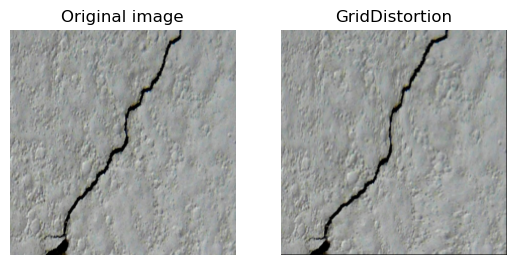

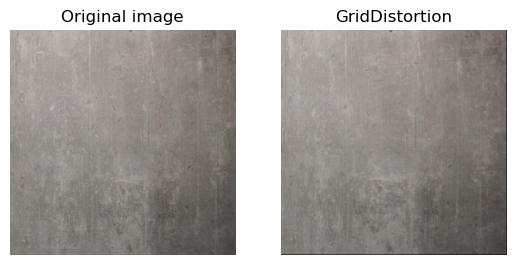

In [38]:
for _ in range(EXMAPLE_PER_TRANSFORM):
    img, _ = get_random_image_and_mask()
    visualise_transform(img,   A.GridDistortion(p=1))

### One of: Random Brightness Contrast or Random Gamma

Some typical tranformation for different illumination

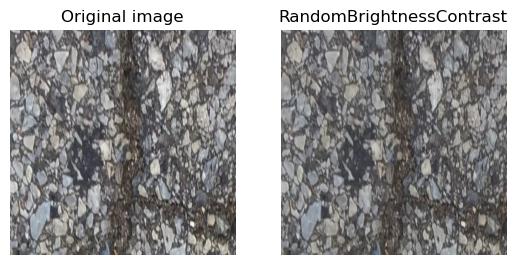

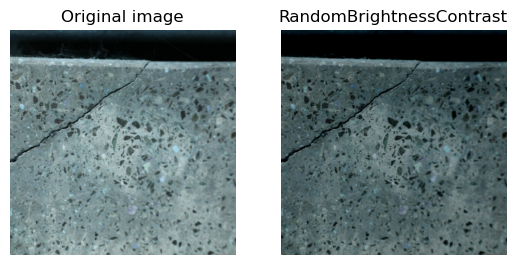

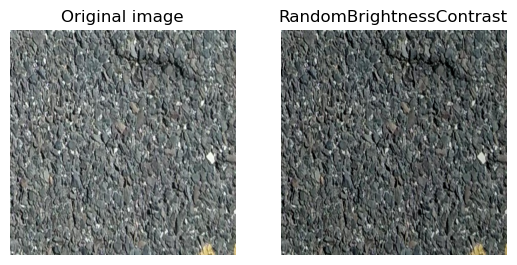

In [127]:
for _ in range(EXMAPLE_PER_TRANSFORM):
    img, _ = get_random_image_and_mask()
    visualise_transform(img, A.RandomBrightnessContrast(p=1))

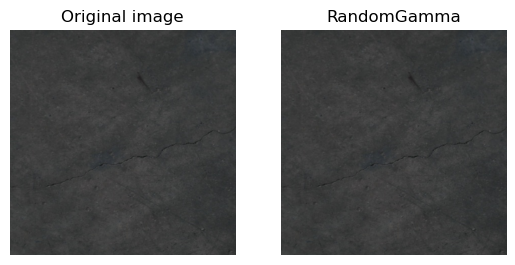

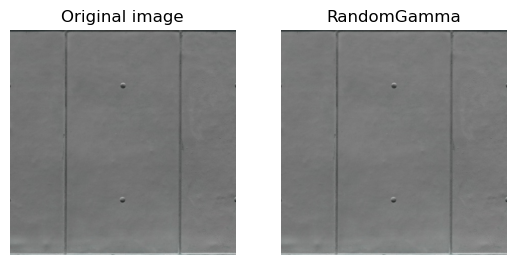

In [40]:
for _ in range(EXMAPLE_PER_TRANSFORM):
    img, _ = get_random_image_and_mask()
    visualise_transform(img, A.RandomGamma(p=1))

# Model Architecture

All of our models are implementations of **U-net neural network**. We tested training the model from scratch as well as performing transfer learning on deeper encoder with weights employed from **resnet34**

## Architecture 1 (scratch)

In [41]:
class Block(nn.Module):
    def __init__(self, in_channels: int, out_channel: int):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channel, kernel_size=3, padding="same", padding_mode="replicate"),
            nn.ReLU(),
            nn.BatchNorm2d(out_channel),
            
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding="same", padding_mode="replicate"),
            nn.ReLU(),
            nn.BatchNorm2d(out_channel),
        )

    def forward(self, X):
        return self.net(X)

class Encoder(nn.Module):
    def __init__(self, channels: tuple[int, ...]):
        super().__init__()
        assert channels[0] < channels[1]

        self.blocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, X):
        downscaled_features = []
        for block in self.blocks:
            X = block(X)
            downscaled_features.append(X)
            X = self.pool(X)

        return downscaled_features

class Decoder(nn.Module):
    def __init__(self, channels: tuple[int, ...]):
        assert channels[0] > channels[1]

        super().__init__()

        self.blocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        self.up_convolution = nn.ModuleList(
            [
                nn.ConvTranspose2d(
                    channels[i], channels[i + 1], kernel_size=2, stride=2
                )
                for i in range(len(channels) - 1)
            ]
        )

    def forward(self, X, downscaled_features):
        for i, block in enumerate(self.blocks):
            X = self.up_convolution[i](X)

            # Adding the previously downscaled feature
            feature = downscaled_features[i]
            _, _, h, w = X.shape
            X = torch.cat([X, feature], dim=1)

            X = block(X)

        return X


class UNet(nn.Module):
    def __init__(
        self, encoding_channels: tuple[int, ...], decoding_channels: tuple[int, ...], output_format=(448,448)
    ):
        super().__init__()
        self.encoder = Encoder(encoding_channels)
        self.decoder = Decoder(decoding_channels)
        self.head_out = nn.Conv2d(decoding_channels[-1], 1, kernel_size=1, padding="same", padding_mode="replicate")
        
        self.output_format = output_format

    def forward(self, X):
        features = self.encoder(X)
        X = self.decoder(features[-1], features[::-1][1:])
        X = self.head_out(X)
       
        return X

In [42]:
endoding_channels = (3, 64, 128, 256, 512, 1024)
decoding_channels = (1024, 512, 256, 128, 64)
model_scratch = UNet(endoding_channels, decoding_channels)
summary(model_scratch, (3,448,448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 448, 448]           1,792
              ReLU-2         [-1, 64, 448, 448]               0
       BatchNorm2d-3         [-1, 64, 448, 448]             128
            Conv2d-4         [-1, 64, 448, 448]          36,928
              ReLU-5         [-1, 64, 448, 448]               0
       BatchNorm2d-6         [-1, 64, 448, 448]             128
             Block-7         [-1, 64, 448, 448]               0
         MaxPool2d-8         [-1, 64, 224, 224]               0
            Conv2d-9        [-1, 128, 224, 224]          73,856
             ReLU-10        [-1, 128, 224, 224]               0
      BatchNorm2d-11        [-1, 128, 224, 224]             256
           Conv2d-12        [-1, 128, 224, 224]         147,584
             ReLU-13        [-1, 128, 224, 224]               0
      BatchNorm2d-14        [-1, 128, 2

## Architecture 2 (Resnet encoder)

In [43]:
import segmentation_models_pytorch as smp

model_transfer = smp.Unet(
    encoder_name="resnet34",       
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)
summary(model_transfer,(3,448,448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          36,864
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
       BasicBlock-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          36,864
      BatchNorm2d-13         [-1, 64, 112, 112]             128
             ReLU-14         [-1, 64, 1

| | Scratch   | Transfer learning with augumention| Transfer learning without augumentation
| --- | -------- | :-------: |---|
|**Dice score**| _No postprocessing_  |     | 0.576 |


# Some predictions

In [94]:
model_scratch.load_state_dict(torch.load("best_model_no_aug_scratch.pth", map_location="cpu", weights_only=True))
model = model_scratch

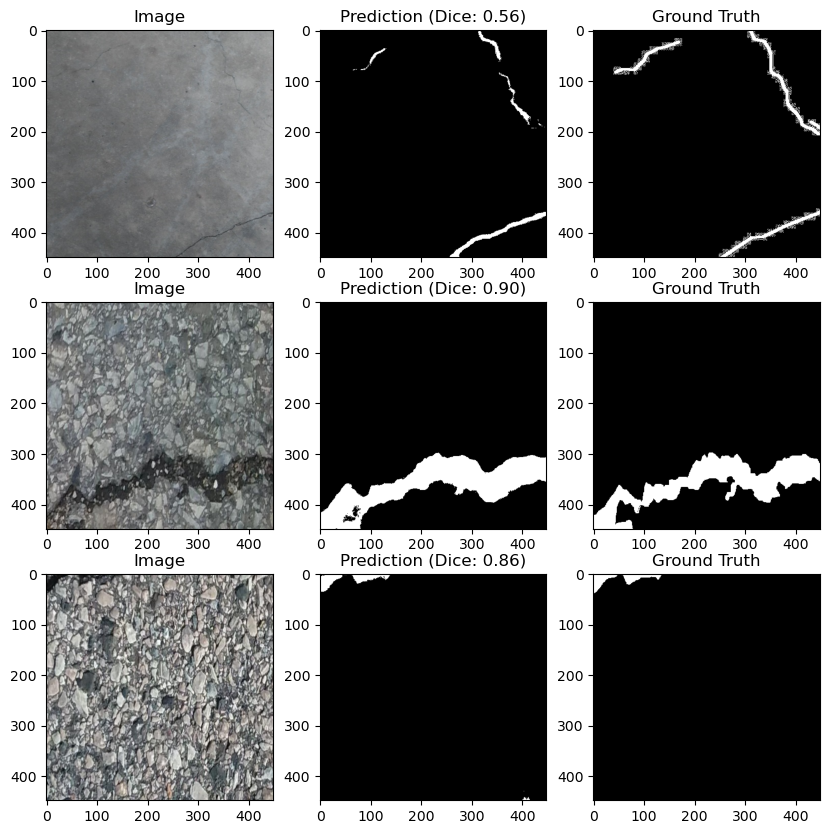

In [98]:
draw_random_predictions(model)

# Postprocessing

We checked noticed that the predicted masks are very similar to the ground truth ones, but they are thicker. We thought that maybe postprocessing the mask with some computer vision operations like _erosion_ or _opening_ could enhance the result, but unfortunately every operation worsened the results

| Postprocessing   | Validation Score |
| -------- | :-------: |
| _No postprocessing_  | 69    |
| Opening | 69    |
| Erosion    | 69   |


# Final results
Our best pipeline turned out to be ????????? with validation score ??????. Manual analysis of the predictions show, that model manages to locate the cracks well
